<a href="https://colab.research.google.com/github/jkrue242/PortfolioOptimization/blob/main/portfolio_optimiztion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Portfolio Optimization using Deep Learning

#### Implementation and modification of [this paper](https://arxiv.org/pdf/2005.13665).

#### Modifications will include:
1. Use of Transformer Networks
2. Hyperparameter optimization
3. Additional input features

### Imports

In [1]:
!pip install ta torch yfinance

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.9 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=09ecab95b6796d3805a8213f3e2ce0280ac0aa957c3dceef51f131641999b4f1
  Stored in direct

In [2]:
import math
import datetime
import warnings
import os
import itertools
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import ta

warnings.filterwarnings("ignore")

torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
np.random.seed(42)

WORK_DIR = os.getcwd()
print(WORK_DIR)

/content


# NOTE: To run on google colab uncomment the next block and update WORK_DIR

In [3]:
from google.colab import drive
drive.mount('/content/drive')

WORK_DIR = '/content/drive/MyDrive/PortfolioOptimization'
import sys
sys.path.append(WORK_DIR)
os.chdir(WORK_DIR)

Mounted at /content/drive


In [4]:
TICKERS = ["VTI", "AGG", "DBC", "^VIX"]
N_ASSETS = len(TICKERS)
TRADING_DAYS = 252
ANNUALIZATION = math.sqrt(TRADING_DAYS)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)

Running on cuda


### Tuneable Parameters

In [9]:
SEQ_LEN = 60
BATCH_SIZE = 64
EMBEDDING_DIM = 128
ATTENTION_HEAD_SIZE = 4
DROPOUT = 0.1
LAYERS = 3
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
START_DATE = "2010-01-01"
END_DATE = "2025-04-29"
TEST_START = "2023-01-01"

### Download Dataset

In [10]:
# loaded locally and saved to parquet format
data = pd.read_parquet(os.path.join(WORK_DIR,'VTI_AGG_DBC_^VIX.parquet'))
print("Timeframe: ", data.index.min().date(), "to", data.index.max().date())
print("Shape:", data.shape)

Timeframe:  2010-01-22 to 2025-04-28
Shape: (3840, 16)


In [11]:
data.head()

,VTI_ret,VTI_rsi,VTI_vol,VTI_cum,AGG_ret,AGG_rsi,AGG_vol,AGG_cum,DBC_ret,DBC_rsi,DBC_vol,DBC_cum,^VIX_ret,^VIX_rsi,^VIX_vol,^VIX_cum
Date,,,,,,,,,,,,,,,,
2010-01-22,-0.022061,28.377418,0.556382,-0.033153,0.000575,69.973764,0.238117,0.011132,-0.010517,16.749482,0.343314,-0.068146,0.226313,84.063244,1.824286,0.362774
2010-01-25,0.004332,31.929415,0.547068,-0.028965,-0.000097,69.558392,0.231997,0.011034,0.004677,21.186989,0.331276,-0.063788,-0.069572,71.669775,1.887551,0.267964
2010-01-26,-0.004492,30.246789,0.547112,-0.033327,0.001245,71.876334,0.227734,0.012293,-0.011003,18.655782,0.331333,-0.074089,-0.033845,66.864562,1.999154,0.225050
2010-01-27,0.004873,34.275059,0.555847,-0.028616,-0.000764,68.426915,0.224723,0.011519,-0.014548,15.969041,0.339501,-0.087559,-0.057434,59.786931,2.038500,0.154691
2010-01-28,-0.011856,29.751779,0.583517,-0.040133,-0.000861,64.664653,0.219086,0.010648,-0.003474,15.406794,0.337723,-0.090729,0.025497,61.617729,2.079322,0.184132


### Plot features

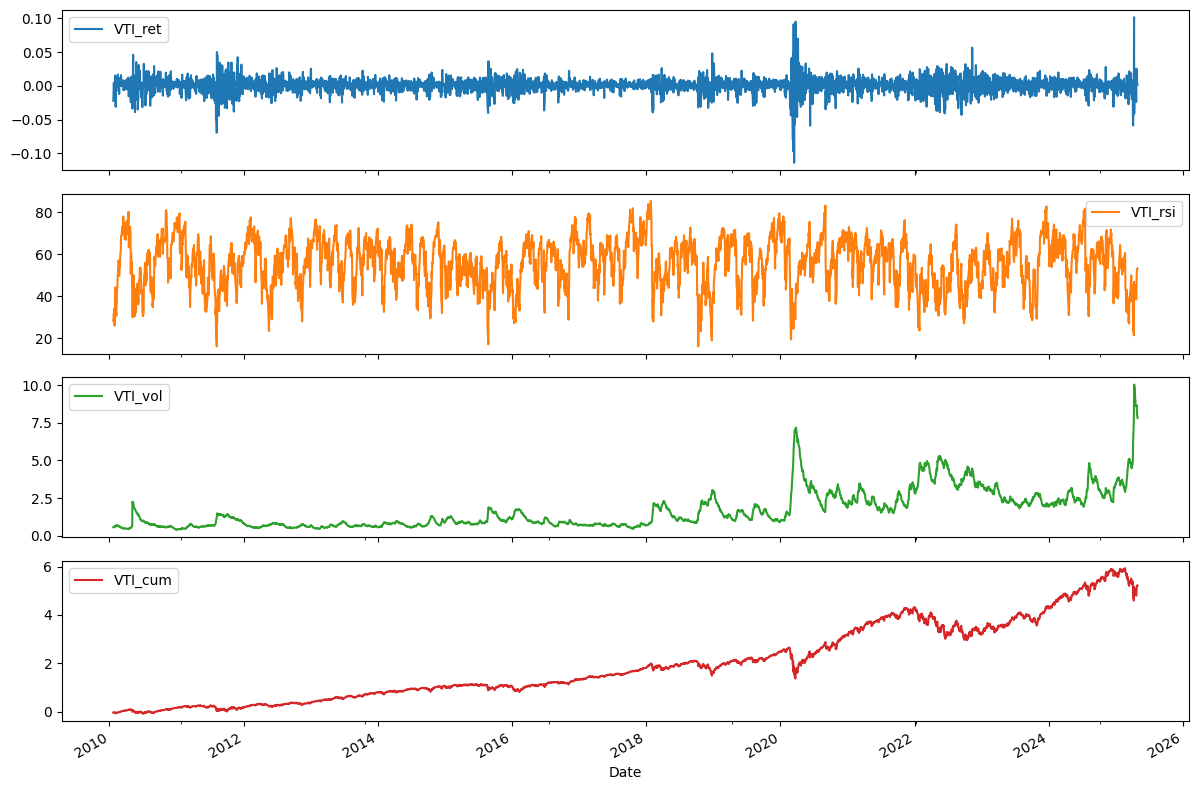

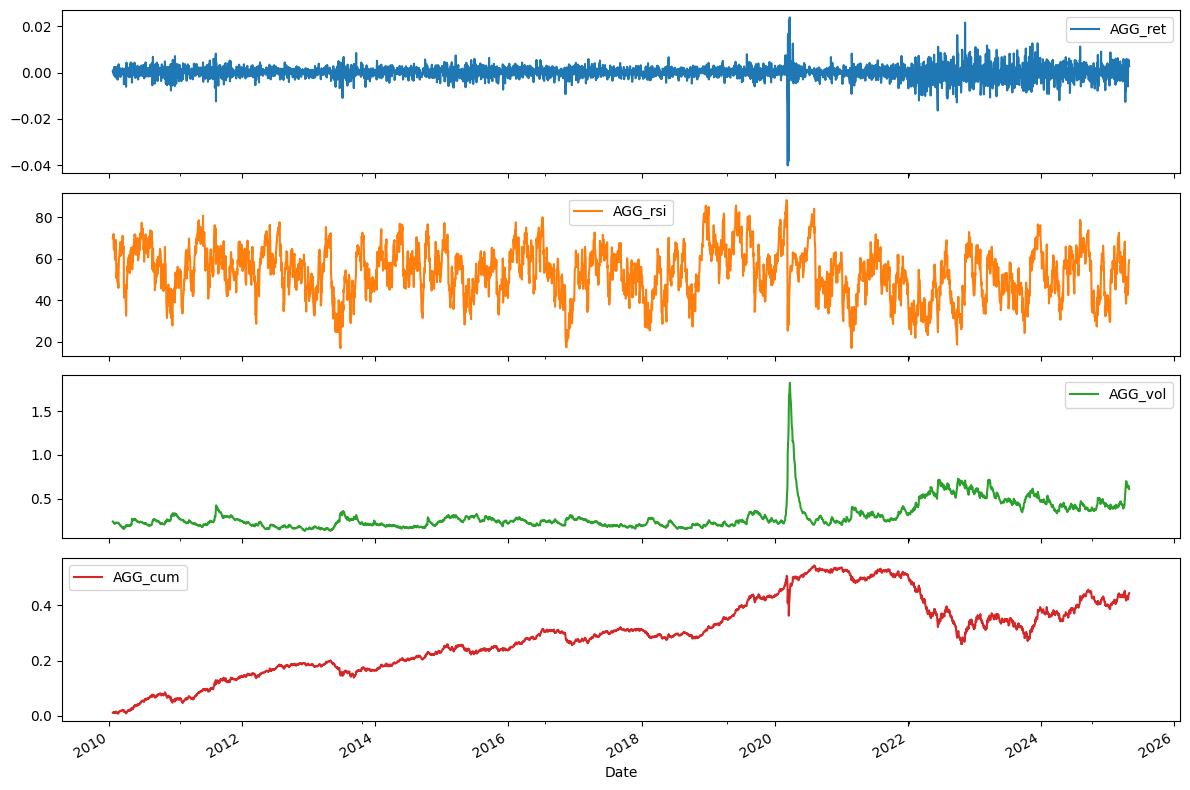

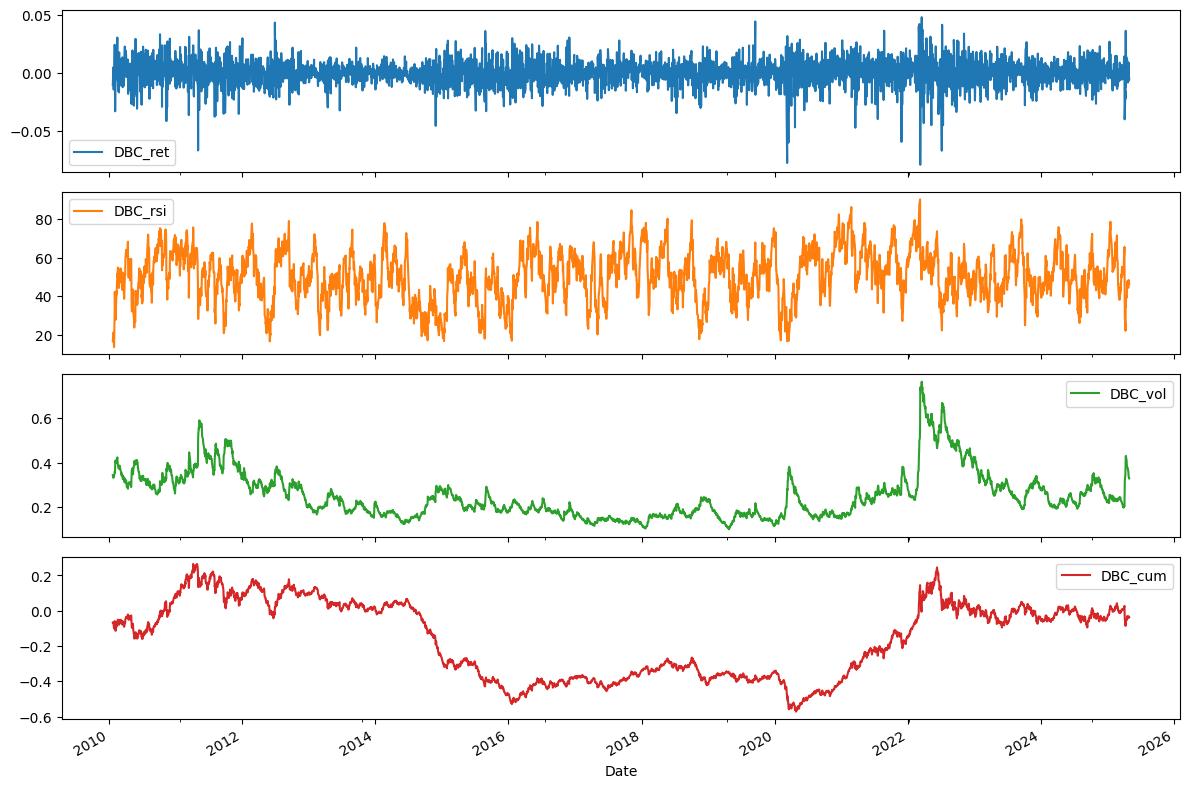

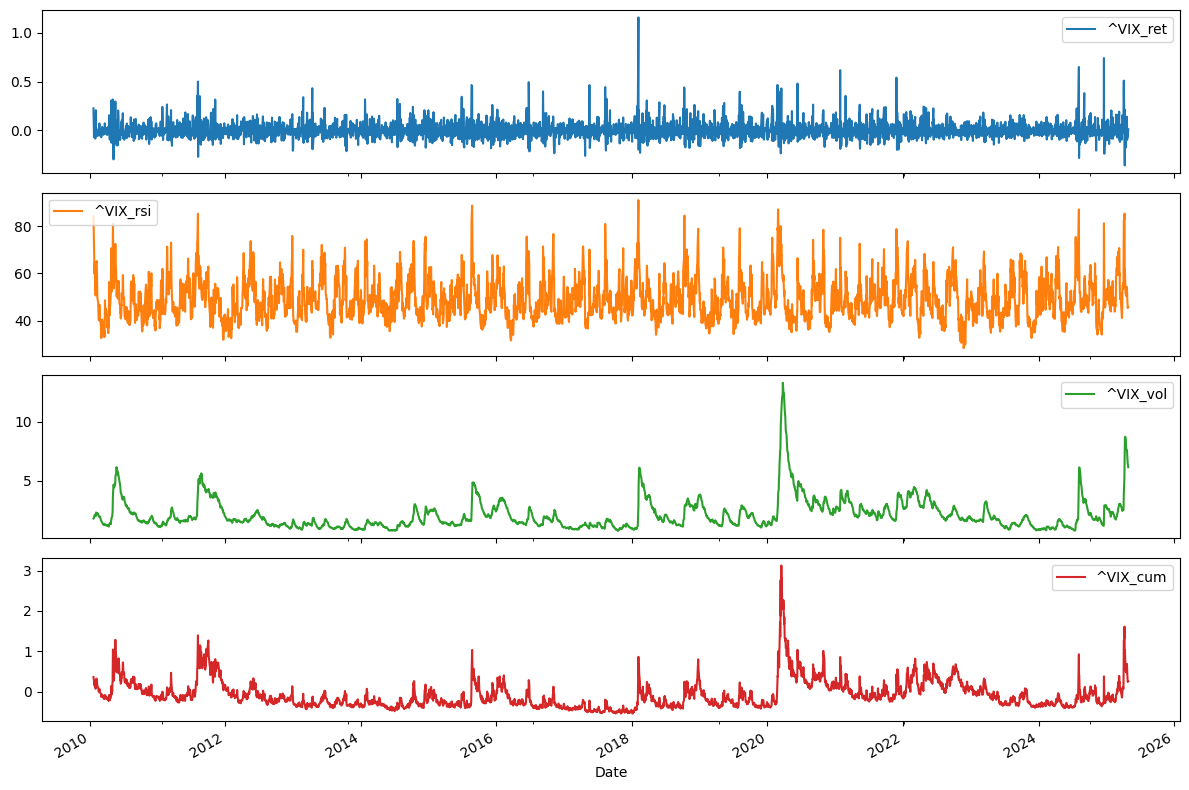

In [12]:
vti_features = data.iloc[:, :4]
vti_features.plot(subplots=True, figsize=(12,8))
plt.tight_layout()
plt.show()

agg_features = data.iloc[:, 4:8]
agg_features.plot(subplots=True, figsize=(12,8))
plt.tight_layout()
plt.show()


dbc_features = data.iloc[:, 8:12]
dbc_features.plot(subplots=True, figsize=(12,8))
plt.tight_layout()
plt.show()

vix_features = data.iloc[:, 12:]
vix_features.plot(subplots=True, figsize=(12,8))
plt.tight_layout()
plt.show()

### Data Loader

In [13]:
class PortfolioDataset(Dataset):
  def __init__(self, df: pd.DataFrame, window: int = SEQ_LEN):
    self.X = df
    self.window = window

    # name of returns columns
    self.ret_cols = [f"{t}_ret" for t in TICKERS]

  def __len__(self):
    return len(self.X) - self.window

  def __getitem__(self, idx):
    # window is the past number of SEQ_LEN days
    win = self.X.iloc[idx : idx+self.window]

    # next step ahead row
    nxt = self.X.iloc[idx+self.window]
    return {
        "features": torch.tensor(win.values, dtype=torch.float32),
        "returns" : torch.tensor(nxt[self.ret_cols].values, dtype=torch.float32),
    }

### Train/Test Split

In [14]:
test_mask = data.index >= pd.to_datetime(TEST_START)
test_df   = data[test_mask]
train_df = data[~test_mask]

train_dl = DataLoader(PortfolioDataset(train_df), BATCH_SIZE, shuffle=True,  drop_last=True)

TRAIN_START, TRAIN_END = train_df.index.min().date(), train_df.index.max().date()
TEST_START,  TEST_END  = test_df.index.min().date(),  test_df.index.max().date()

print(f"Train [{TRAIN_START} - {TRAIN_END}] : {len(train_dl.dataset)} samples")
print(f"Test  [{TEST_START}  - {TEST_END}]  : {len(test_df)} samples")


Train [2010-01-22 - 2022-12-30] : 3199 samples
Test  [2023-01-03  - 2025-04-28]  : 581 samples


### Custom Sharpe Ratio Loss Function
Minimize the negative annualized sharpe

In [15]:
def sharpe(mu, sigma, prevent_div_0: bool = False):
  eps = 0
  if sigma == 0 and not prevent_div_0:
    return np.nan

  if prevent_div_0:
    eps = 1e-6

  # annualize
  return mu /(sigma + eps) * ANNUALIZATION

class SharpeLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, weights: torch.Tensor, returns: torch.Tensor):
    # daily returns
    portfolio_returns = (weights * returns).sum(-1)
    mean = portfolio_returns.mean()

    # volatility
    std  = portfolio_returns.std(unbiased=False)
    return -1 * sharpe(mean, std, prevent_div_0=True)

### Transformer Model

In [16]:
class PosEnc(nn.Module):
  def __init__(self, d: int, max_len: int = 512):
    super().__init__()
    P = torch.zeros(max_len, d)
    pos = torch.arange(max_len).unsqueeze(1)
    div = torch.exp(torch.arange(0, d, 2) * (-math.log(1e4)/d))

    # sine encoding
    P[:, 0::2] = torch.sin(pos * div)

    # cosine encoding
    P[:, 1::2] = torch.cos(pos * div)
    self.register_buffer("P", P.unsqueeze(0))

  def forward(self, x):
    return x + self.P[:, :x.size(1)]

In [17]:
class BaseTransformer(nn.Module):
  # seq-to-one
  def __init__(self, d_in: int):
    super().__init__()

    # embedding layer
    self.input_linear  = nn.Linear(d_in, EMBEDDING_DIM)

    # positional encoding
    self.position_encoding  = PosEnc(EMBEDDING_DIM, SEQ_LEN)

    # encoder layer
    enc_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM,
                                            nhead=ATTENTION_HEAD_SIZE,
                                            dim_feedforward=EMBEDDING_DIM*2,
                                            batch_first=True,
                                            dropout=DROPOUT)

    # transformer encoder
    self.encoder  = nn.TransformerEncoder(enc_layer, LAYERS)

    # output
    self.output_linear = nn.Linear(EMBEDDING_DIM, N_ASSETS)

  def forward(self, x):
    y = self.input_linear(x)
    y = self.position_encoding(y)
    y = self.encoder(y)[:, -1]
    y = F.softmax(self.output_linear(y), dim=-1)
    return y

### Training Loop

In [18]:
feature_dim = train_df.shape[1]
model = BaseTransformer(feature_dim)

# load model to evice
model.to(DEVICE)
loss_fn = SharpeLoss()
opt = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

# save history when training
history = {"train": []}

for ep in range(1, EPOCHS + 1):

  # set to train mode
  model.train()

  # clear iteration loss
  epoch_loss = 0
  for batch in train_dl:

    # clear gradient
    opt.zero_grad()

    # load features and returns to device
    features = batch["features"].to(DEVICE)
    returns = batch["returns"].to(DEVICE)

    # get loss
    loss = loss_fn(model(features), returns)

    # backprop
    loss.backward()

    # optimize
    opt.step()

    # update loss
    epoch_loss += loss.item()

  # back to positive sharpe
  train_sh = -epoch_loss / len(train_dl)
  history["train"].append(train_sh)

  sched.step()
  if ep % 10 == 0:
    print(f"Epoch {ep}/{EPOCHS} | train Sharpe={train_sh:6.3f}")

Epoch 10/100 | train Sharpe= 1.610
Epoch 20/100 | train Sharpe= 2.778
Epoch 30/100 | train Sharpe= 3.113
Epoch 40/100 | train Sharpe= 3.216
Epoch 50/100 | train Sharpe= 3.791
Epoch 60/100 | train Sharpe= 3.871
Epoch 70/100 | train Sharpe= 4.448
Epoch 80/100 | train Sharpe= 4.920
Epoch 90/100 | train Sharpe= 5.110
Epoch 100/100 | train Sharpe= 5.528


In [19]:
print(model)

BaseTransformer(
  (input_linear): Linear(in_features=16, out_features=128, bias=True)
  (position_encoding): PosEnc()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_linear): Linear(in_features=128, out_features=4, bias=True)
)


### Save training run data

In [20]:
import time

dir = str(time.time())
os.makedirs(dir)
torch.save(model.state_dict(), os.path.join(dir, "model.pt"))

### Save metadata

In [21]:
metadata = f"""
  SEQ_LEN = {SEQ_LEN}
  BATCH_SIZE = {BATCH_SIZE}
  EMBEDDING_DIM = {EMBEDDING_DIM}
  ATTENTION_HEAD_SIZE = {ATTENTION_HEAD_SIZE}
  DROPOUT = {DROPOUT}
  LAYERS = {LAYERS}
  EPOCHS  = {EPOCHS}
  LEARNING_RATE = {LEARNING_RATE}
  WEIGHT_DECAY = {WEIGHT_DECAY}
  START_DATE = {START_DATE}
  END_DATE   = {END_DATE}
  TEST_START = {TEST_START}
"""

with open(os.path.join(dir, "metadata.txt"), "w", encoding="utf-8") as f:
    f.write(metadata)

### Training Curves

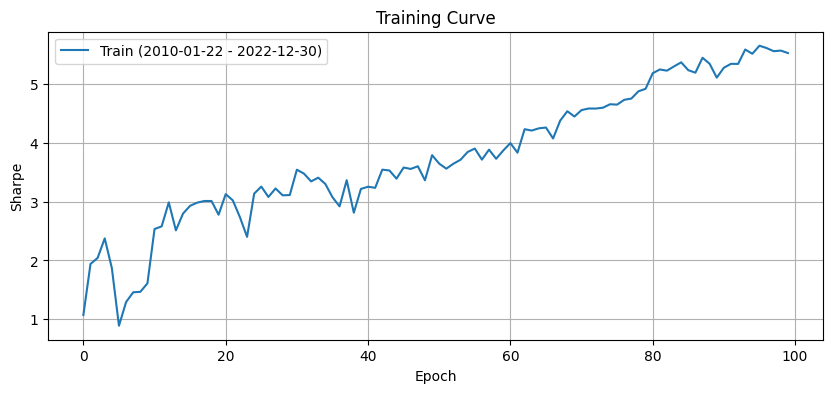

<Figure size 640x480 with 0 Axes>

In [22]:
plt.figure(figsize=(10,4))
plt.plot(history["train"], label=f"Train ({TRAIN_START} - {TRAIN_END})")
plt.title("Training Curve")
plt.ylabel("Sharpe")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.savefig(os.path.join(dir, "training.png"))

### Testing

In [23]:
model.eval()
model.to(DEVICE)

dates_test = test_df.index
weights_history = []
portfolio_returns = []
ticker_returns = test_df[[f"{t}_ret" for t in TICKERS]].values

with torch.no_grad():
  for i, day in enumerate(dates_test):
    start = data.index.get_loc(day) - SEQ_LEN
    window = torch.tensor(data.iloc[start:start+SEQ_LEN].values, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    w = model(window).squeeze().cpu().numpy()
    weights_history.append(w)
    portfolio_returns.append((w * ticker_returns[i]).sum())

weights_history = np.array(weights_history)
portfolio_returns = np.array(portfolio_returns)

### Plot and Compare Results

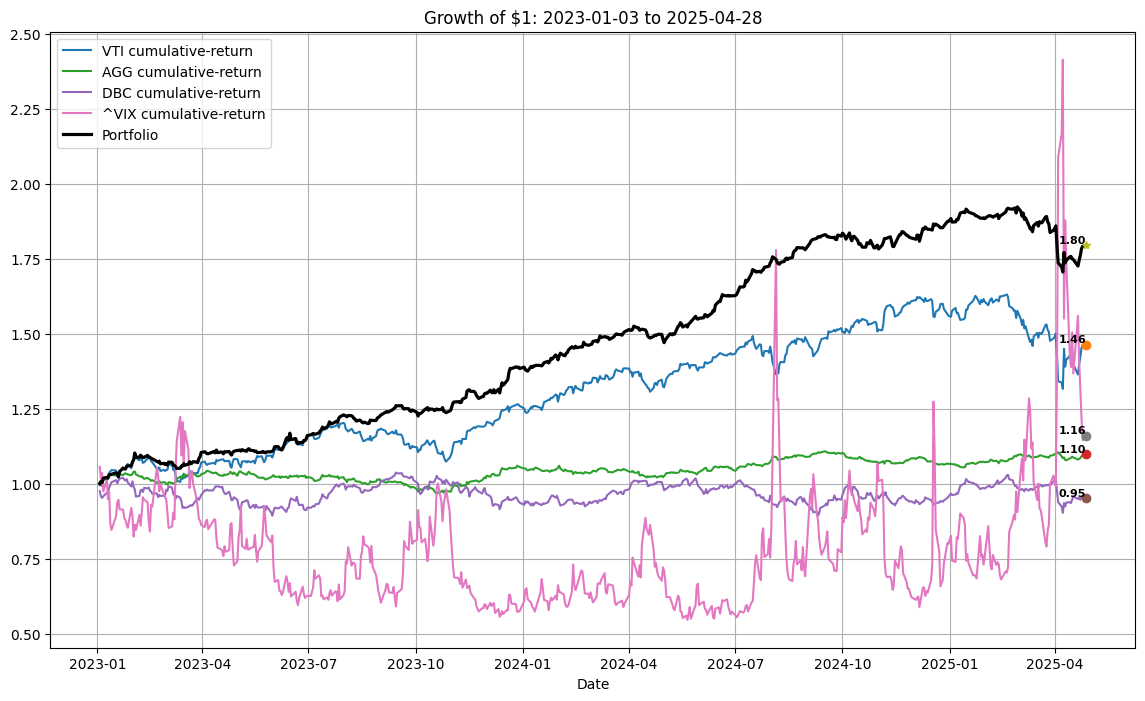

1746930846.064294


<Figure size 640x480 with 0 Axes>

In [24]:
ticker_cumulative = (1 + ticker_returns).cumprod(axis=0)
portfolio_cumulative = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(14, 8))
for i, t in enumerate(TICKERS):
  plt.plot(dates_test, ticker_cumulative[:, i], label=f"{t} cumulative-return")
  plt.plot(dates_test[-1], ticker_cumulative[-1, i], marker="o")
  plt.text(dates_test[-1], ticker_cumulative[-1, i], f"{ticker_cumulative[-1, i]:.2f}", fontsize=8, fontweight="bold", va="bottom", ha="right")

plt.plot(dates_test, portfolio_cumulative, color="k", lw=2.3, label="Portfolio")
plt.plot(dates_test[-1], portfolio_cumulative[-1], marker="*")
plt.text(dates_test[-1], portfolio_cumulative[-1], f"{portfolio_cumulative[-1]:.2f}", fontsize=8, fontweight="bold",va="bottom", ha="right")

plt.title(f"Growth of $1: {TEST_START} to {TEST_END}")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

print(dir)
plt.savefig(os.path.join(dir, "returns"))

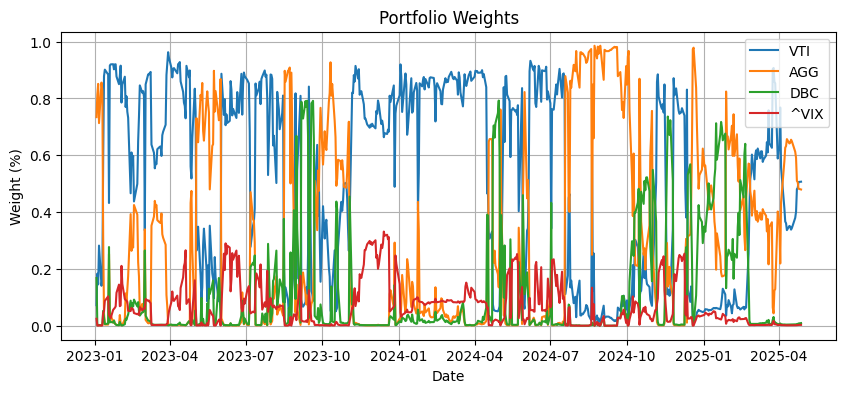

<Figure size 640x480 with 0 Axes>

In [25]:
plt.figure(figsize=(10, 4))
for i, t in enumerate(TICKERS):
  plt.plot(dates_test, weights_history[:, i], label=t)
plt.title("Portfolio Weights")
plt.xlabel("Date")
plt.ylabel("Weight (%)")
plt.legend()
plt.grid(True)
plt.show()

plt.savefig(os.path.join(dir, "portfolio_weights.png"))

In [26]:
def yearly_sharpe(series):
  def helper(x):
    mu = x.mean()
    sigma = x.std()
    return sharpe(mu, sigma)
  return series.groupby(series.index.year).apply(helper)

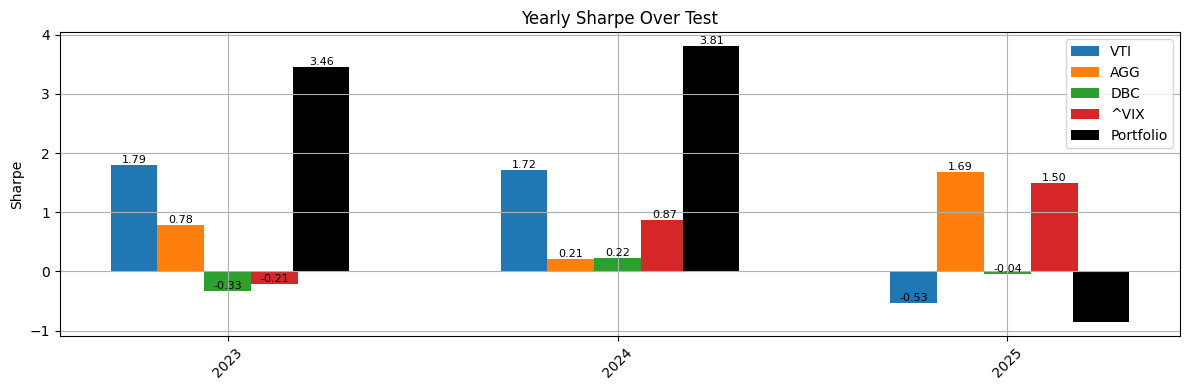

<Figure size 640x480 with 0 Axes>

In [27]:
portfolio_series = pd.Series(portfolio_returns, index=dates_test)
ticker_dataframe = pd.DataFrame(ticker_returns, index=dates_test, columns=TICKERS)

sharpe_portfolio = yearly_sharpe(portfolio_series)
sharpe_tickers   = ticker_dataframe.apply(yearly_sharpe)

years = sharpe_portfolio.index.astype(str)
x = np.arange(len(years))
width = 0.12

plt.figure(figsize=(12, 4))

for j, t in enumerate(TICKERS):
  bars = plt.bar(x + j*width, sharpe_tickers[t].values, width=width, label=t)
  for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{h:.2f}", ha="center", va="bottom", fontsize=8)

bars_port = plt.bar(x + len(TICKERS)*width, sharpe_portfolio.values, width=width*1.2, color="k", label="Portfolio")
for bar in bars_port:
  h = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, h, f"{h:.2f}", ha="center", va="bottom", fontsize=8)

plt.xticks(x + width * len(TICKERS)/2, years, rotation=45)
plt.ylabel("Sharpe")
plt.title("Yearly Sharpe Over Test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(dir, "histogram.png"))

## Evaluation

In [28]:
def max_drawdown(cumulative_returns):
  roll_max = np.maximum.accumulate(cumulative_returns)
  drawdown = 1 - cumulative_returns / roll_max
  return np.max(drawdown)

In [29]:
def downside_dev(returns, periods=TRADING_DAYS):
  # only use negative events
  downside = np.clip(0.0 - returns, 0, None)
  return np.sqrt(np.mean(downside**2)) * np.sqrt(TRADING_DAYS)

In [30]:
def sortino(returns):
  ann_return = returns.mean() * TRADING_DAYS
  dd = downside_dev(returns)
  return ann_return / dd if dd != 0 else np.nan

In [31]:
def build_metrics_dict(returns, cumulative):
  return dict(
    AnnRet   = returns.mean() * TRADING_DAYS,
    AnnStd   = returns.std() * TRADING_DAYS,
    DownDev  = downside_dev(returns),
    Sharpe   = sharpe(returns.mean(), returns.std()),
    Sortino  = sortino(returns),
    MDD      = max_drawdown(cumulative)
)

### Allocation Scheme Comparison

In [32]:
returns_df = pd.read_parquet(os.path.join(WORK_DIR, "ticker_returns.parquet"))
returns_df.head()

,VTI,AGG,DBC,^VIX
Date,,,,
2023-01-03,-0.004080,0.005877,-0.023935,0.056760
2023-01-04,0.008875,0.005535,-0.017872,-0.038865
2023-01-05,-0.011713,-0.000816,-0.005078,0.020445
2023-01-06,0.022070,0.010916,0.005530,-0.059216
2023-01-09,0.000412,0.002523,0.011844,0.039754


In [33]:
alloc_tickers = ["VTI", "AGG", "DBC", "^VIX"]

bench_weights = {
  "Allocation 1": np.array([0.25, 0.25, 0.25, 0.25]),
  "Allocation 2": np.array([0.50, 0.10, 0.20, 0.20]),
  "Allocation 3": np.array([0.10, 0.50, 0.20, 0.20]),
  "Allocation 4": np.array([0.40, 0.40, 0.10, 0.10]),
}

bench_returns   = {}
bench_cumulative = {}
metrics = {}
metrics["Model"] = build_metrics_dict(portfolio_returns, portfolio_cumulative)

for name, w in bench_weights.items():
  returns = returns_df[alloc_tickers].values @ w
  bench_returns[name] = returns
  bench_cumulative[name] = np.cumprod(1 + returns)

for name in bench_weights:
  r = bench_returns[name]
  cum = bench_cumulative[name]
  metrics[name] = build_metrics_dict(r, cum)


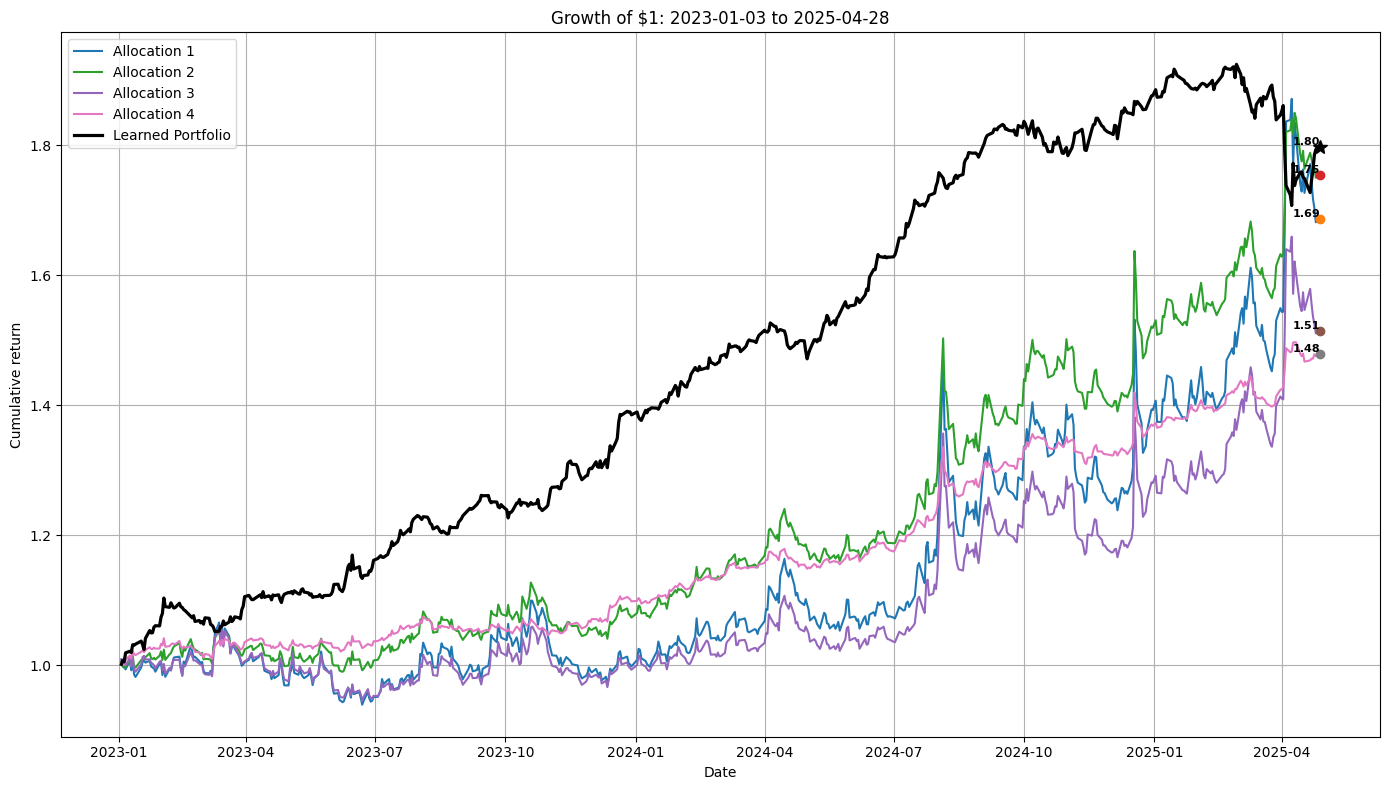

Figure saved to 1746930846.064294/cumulative_returns.png


In [34]:
plt.figure(figsize=(14, 8))

for name, cum in bench_cumulative.items():
    plt.plot(dates_test, cum, label=name)
    plt.plot(dates_test[-1], cum[-1], marker="o")
    plt.text(dates_test[-1], cum[-1],
             f"{cum[-1]:.2f}",
             fontsize=8, fontweight="bold",
             va="bottom", ha="right")

plt.plot(dates_test, portfolio_cumulative,
         color="k", lw=2.3, label="Learned Portfolio")
plt.plot(dates_test[-1], portfolio_cumulative[-1],
         marker="*", color="k", markersize=10)
plt.text(dates_test[-1], portfolio_cumulative[-1],
         f"{portfolio_cumulative[-1]:.2f}",
         fontsize=8, fontweight="bold",
         va="bottom", ha="right")

plt.title(f"Growth of $1: {TEST_START} to {TEST_END}")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.legend()
plt.grid(True)
plt.tight_layout()


file_path = os.path.join(dir, "cumulative_returns.png")
plt.savefig(file_path, dpi=300)
plt.show()

print(f"Figure saved to {file_path}")


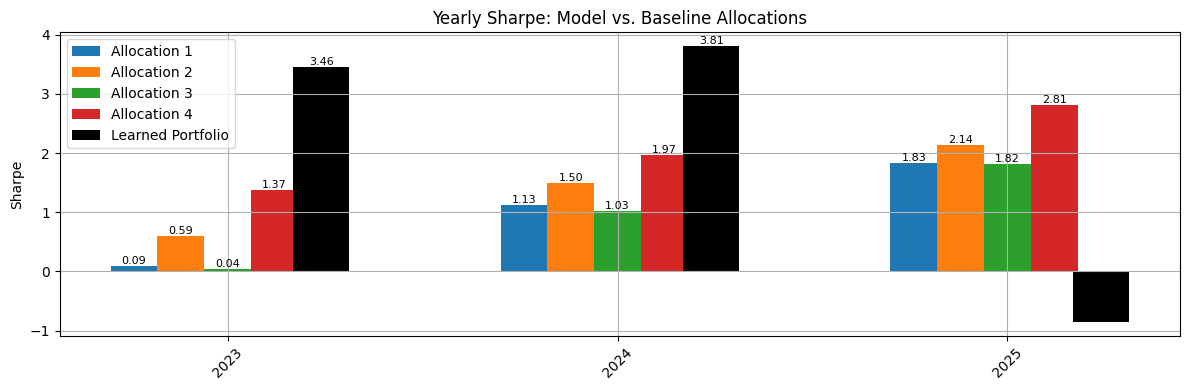

In [35]:
baseline_df = pd.DataFrame({name: bench_returns[name] for name in bench_weights}, index=dates_test)
portfolio_series = pd.Series(portfolio_returns, index=dates_test)

sharpe_port = yearly_sharpe(portfolio_series)
sharpe_baseline = baseline_df.apply(yearly_sharpe)

years  = sharpe_port.index.astype(str)
x      = np.arange(len(years))
width  = 0.12

plt.figure(figsize=(12, 4))

for j, name in enumerate(baseline_df.columns):
  bars = plt.bar(x + j*width, sharpe_baseline[name].values, width=width, label=name)
  for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{h:.2f}", ha="center", va="bottom", fontsize=8)

bars_port = plt.bar(x + len(baseline_df.columns)*width, sharpe_port.values, width=width*1.2, color="k", label="Learned Portfolio")
for bar in bars_port:
  h = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, h,  f"{h:.2f}",  ha="center", va="bottom", fontsize=8)

plt.xticks(x + width * len(baseline_df.columns)/2, years, rotation=45)
plt.ylabel("Sharpe")
plt.title("Yearly Sharpe: Model vs. Baseline Allocations")
plt.legend()
plt.grid(True)
plt.tight_layout()


In [36]:
compare_df = pd.DataFrame(metrics).T.rename(columns={
  "AnnRet":  "Return (%)",
  "AnnStd":  "Std (%)",
  "DownDev": "Downside Deviation (%)",
  "Sharpe":  "Sharpe",
  "Sortino": "Sortino",
  "MDD":     "Max Drawdown (%)"
})

pct_cols = ["Return (%)", "Std (%)", "Downside Deviation (%)", "Max Drawdown (%)"]
compare_df[pct_cols] = compare_df[pct_cols] * 100

results_df = compare_df.round({
  "Return (%)": 2,
  "Std (%)": 2,
  "Downside Deviation (%)": 2,
  "Sharpe": 2,
  "Sortino": 2,
  "Max Drawdown (%)": 2
})

results_df.head()

,Return (%),Std (%),Downside Deviation (%),Sharpe,Sortino,Max Drawdown (%)
Model,25.92,157.64,6.04,2.61,4.29,11.28
Allocation 1,26.87,468.11,15.64,0.91,1.72,18.29
Allocation 2,26.43,326.24,10.51,1.29,2.52,12.94
Allocation 3,21.00,392.89,13.30,0.85,1.58,15.54
Allocation 4,17.41,150.11,4.84,1.84,3.60,5.70


### Plot metrics

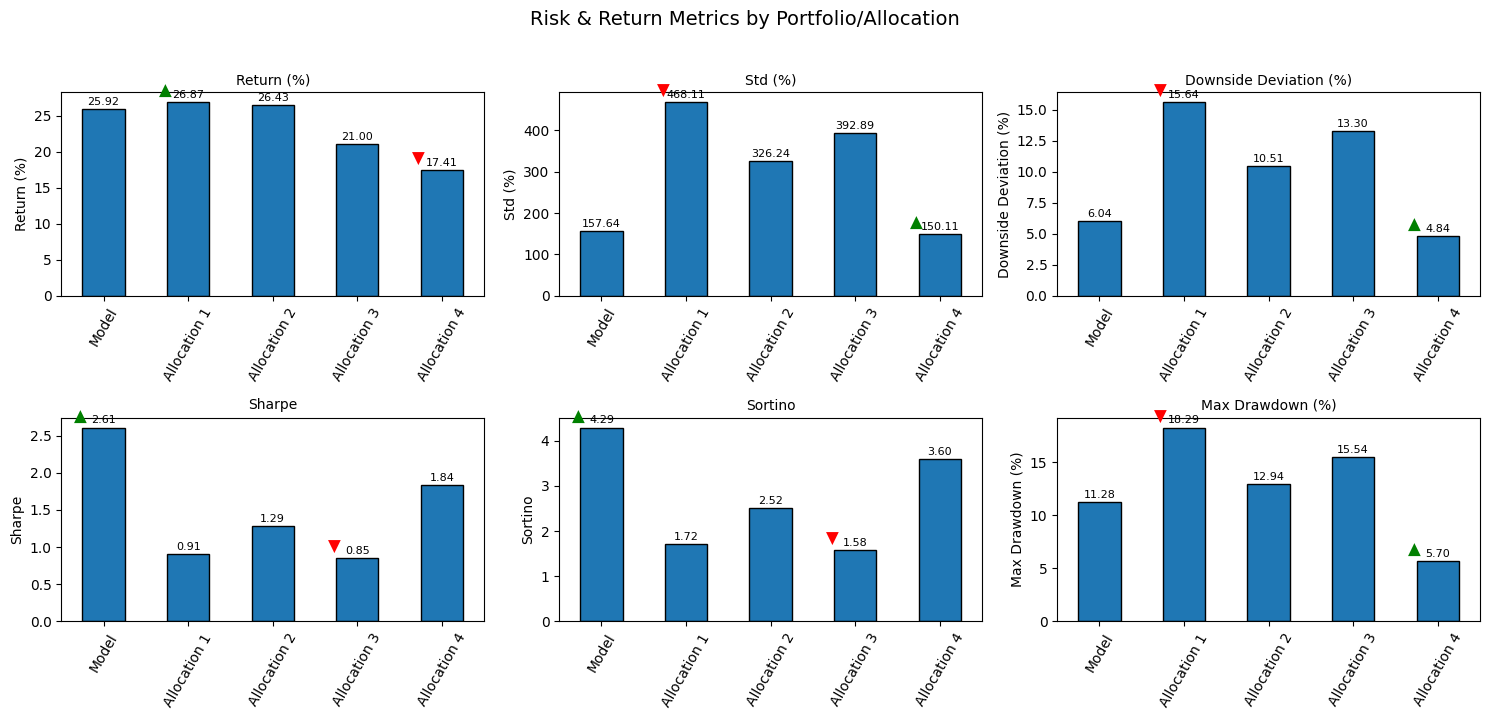

<Figure size 640x480 with 0 Axes>

In [37]:
compare_df = (
  pd.DataFrame(metrics).T.rename(columns={
    "AnnRet":  "Return (%)",
    "AnnStd":  "Std (%)",
    "DownDev": "Downside Deviation (%)",
    "Sharpe":  "Sharpe",
    "Sortino": "Sortino",
    "MDD":     "Max Drawdown (%)",
  })
)

pct_cols = ["Return (%)", "Std (%)", "Downside Deviation (%)", "Max Drawdown (%)"]
compare_df[pct_cols] *= 100

metric_cols = [
  "Return (%)", "Std (%)", "Downside Deviation (%)",
  "Sharpe", "Sortino", "Max Drawdown (%)"
]

best_rule = {
  "Sharpe": "max",
  "Sortino": "max",
  "Return (%)": "max",
  "Std (%)": "min",
  "Downside Deviation (%)": "min",
  "Max Drawdown (%)": "min",
}

fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.ravel()

for ax, col in zip(axes, metric_cols):
  compare_df[col].plot(kind="bar", ax=ax, edgecolor="black")
  ax.set_title(col, fontsize=10)
  ax.set_ylabel(col)
  ax.tick_params(axis="x", rotation=60)

  y_min, y_max = ax.get_ylim()
  y_offset = (y_max - y_min) * 0.01

  for bar in ax.patches:
    h = bar.get_height()
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      h + y_offset,
      f"{h:.2f}",
      ha="center", va="bottom", fontsize=8
    )

  # plot best and worst ones
  vals = compare_df[col].values
  if best_rule[col] == "max":
    best_idx, worst_idx = np.argmax(vals), np.argmin(vals)
  else:  # "min"
    best_idx, worst_idx = np.argmin(vals), np.argmax(vals)

  def place_marker(idx, marker, color):
    bar   = ax.patches[idx]
    h_val = bar.get_height()
    x_num = bar.get_x() + bar.get_width() / 2
    x_tri = x_num + bar.get_width() * -0.7 # put marker on left
    ax.text(
      x_tri,
      h_val + y_offset,
      marker,
      ha="left", va="bottom",
      fontsize=12, color=color, weight="bold",
      clip_on=False
    )

  # ▲ best , ▼ worst
  place_marker(best_idx, "▲", "green")
  place_marker(worst_idx, "▼", "red")

plt.suptitle("Risk & Return Metrics by Portfolio/Allocation", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(dir, "results.png"))